Voltage set to: -2.0 V
--> Current = -4.615336e-08 mA
--> Photocurrent = 1.237403e-08 mA
Voltage set to: -1.7954545454545454 V
--> Current = 7.81808e-09 mA
--> Photocurrent = 3.831683e-09 mA
Voltage set to: -1.5909090909090908 V
--> Current = 1.7228729999999998e-08 mA
--> Photocurrent = 1.268955e-09 mA
Voltage set to: -1.3863636363636362 V
--> Current = 1.753407e-08 mA
--> Photocurrent = 3.4799140000000003e-09 mA
Voltage set to: -1.1818181818181817 V
--> Current = 2.185778e-08 mA
--> Photocurrent = 8.669697000000001e-10 mA
Voltage set to: -0.9772727272727273 V
--> Current = 2.216306e-08 mA
--> Photocurrent = 2.776453e-09 mA
Voltage set to: -0.7727272727272727 V
--> Current = 2.679199e-08 mA
--> Photocurrent = 2.424708e-09 mA
Voltage set to: -0.5681818181818181 V
--> Current = 3.1471890000000003e-08 mA
--> Photocurrent = 3.17844e-09 mA
Voltage set to: -0.36363636363636354 V
--> Current = 2.77077e-08 mA
--> Photocurrent = 1.282627e-08 mA
Voltage set to: -0.15909090909090895 V
--> Current

NameError: name 'st' is not defined

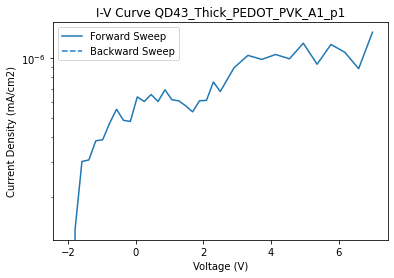

In [1]:
'''
Keithley I-V Sweep + Spectra 
by Gillian Shen, University  of Washington

Modified by Helen Kuang


Keithley I-V Sweep
Modified by Gillian Shen, May 2022, from 
Demis D. John, October 2014, Univ. of California Santa Barbara
Program to sweep voltage & measure current on Keithley SMU
Based off Steve Nichols' Script from ~2010, Univ. of California Santa Barbara

'''
#IV-Sweep Credits to:
#https://github.com/demisjohn/Keithley-I-V-Sweep

import pyvisa        # PyVISA module, for GPIB comms
import numpy as np  # enable NumPy numerical analysis
import time          # to allow pause between measurements
import os            # Filesystem manipulation - mkdir, paths etc.
import matplotlib.pyplot as plt # for python-style plottting, like 'ax1.plot(x,y)'
from datetime import date

#PARAMETERS
SaveFiles = True  # Save the plot & data?  Only display if False.
ReverseSweep = False   # Save the plot & data?  Only display if False.
Sample_Name = "QD43_Thick_PEDOT_PVK_A1_p1"       #sample number
sleep_time = 0.05 #seconds
CurrentCompliance = 1    # compliance (max) current (A)
start = -2    # starting value of Voltage sweep
stop = 7      # ending value 
transition = 2.5
numpoints1 = 23  # number of points in sweep
numpoints2 = 12
#--------------------------------------------------------------------------

today = date.today()
date_string = date.isoformat(today)
#     date_string

rm = pyvisa.ResourceManager()
#     rm.list_resources()

keithley = rm.open_resource('GPIB0::24::INSTR')
keithley2 = rm.open_resource('GPIB0::25::INSTR') #photocurrent measure

#--------------------------------------------------------------------------

# Setup electrodes as voltage source
keithley.write("*RST")
#print("reset the instrument")
time.sleep(0.5)    # add second between
keithley.write(":SOUR:FUNC:MODE VOLT")
keithley.write(":SENS:CURR:PROT:LEV " + str(CurrentCompliance))
keithley.write(":SENS:CURR:RANGE:AUTO 1")   # set current reading range to auto (boolean)
keithley.write(":OUTP ON")                    # Output on    

#Configuring Keithley 2 for photocurrent measurement. Same as above except without voltage source mode
keithley2.write("*RST")

#Measuring photocurrent
keithley2.write(":SENS:CURR:PROT:LEV " + str(CurrentCompliance))
keithley2.write(":SENS:CURR:RANGE:AUTO 1")   # set current reading range to auto (boolean)

keithley2.write(":OUTP ON")                    # Output on

# Loop to sweep voltage, collect photocurrent
part1 = np.linspace(start, transition, num=numpoints1, endpoint=True)
part1 = np.delete(part1, len(part1)-1)
part2 = np.linspace(transition, stop, num=numpoints2, endpoint=True)
Volts = np.append(part1,part2)
numpoints = numpoints1+numpoints2-1

Voltage=[]
Current = []
Photocurrent = []
voltage_count=0
ReverseVoltage=[]
ReverseCurrent=[]
ReversePhotocurrent=[]

for V in Volts:
    #Voltage.append(V)
    print("Voltage set to: "+str(V)+" V")
    keithley.write(":SOUR:VOLT " + str(V))
    time.sleep(sleep_time)    # add second between
    data = keithley.query(":READ?")   #returns string with many values (V, I, ...)
    answer = data.split(',')    # remove delimiters, return values into list elements
    I = eval(answer.pop(1)) * 1e3     # convert to number
    Current.append(I)

    vread = eval(answer.pop(0))
    Voltage.append(vread)
    print("--> Current = " + str(Current[-1]) + ' mA') 

    #Now photocurrent
    data2 = keithley2.query(":READ?")   #returns string with many values (V, I, ...)
    answer2 = data2.split(',')    # remove delimiters, return values into list elements
    PhotocurrentI = eval(answer2.pop(1)) * 1e3     # convert to number
    if V == 0:
        Dark_photocurrent = PhotocurrentI
    Photocurrent.append(PhotocurrentI)
    print("--> Photocurrent = " + str(Photocurrent[-1]) + ' mA')   # print last read value

    voltage_count+=1
    #end for(V)
if ReverseSweep:
    #New for reverse sweep
    for V in reversed(Volts):
        #Voltage.append(V)
        print("Voltage set to: "+str(V)+" V")
        keithley.write(":SOUR:VOLT " + str(V))
        time.sleep(sleep_time)    # add second between
        data = keithley.query(":READ?")   #returns string with many values (V, I, ...)
        answer = data.split(',')    # remove delimiters, return values into list elements
        I = eval(answer.pop(1)) * 1e3     # convert to number
        ReverseCurrent.append(I)

        vread = eval(answer.pop(0))
        ReverseVoltage.append(vread)
        print("--> Current = " + str(Current[-1]) + ' mA') 

        #Now photocurrent
        data2 = keithley2.query(":READ?")   #returns string with many values (V, I, ...)
        answer2 = data2.split(',')    # remove delimiters, return values into list elements
        PhotocurrentI = eval(answer2.pop(1)) * 1e3     # convert to number
        if V == 0:
            Dark_photocurrent = PhotocurrentI
        ReversePhotocurrent.append(PhotocurrentI)
        print("--> Photocurrent = " + str(Photocurrent[-1]) + ' mA')   # print last read value

        voltage_count+=1
        #end for(V)


keithley.write(":OUTP OFF")     # turn off
keithley.write("SYSTEM:KEY 23") # go to local control
#keithley.close()

#keithley2.write(":OUTP OFF")     # turn off
#keithley2.write("SYSTEM:KEY 23") # go to local control
#keithley2.close()


#     #set to current source, voltage meas
#     keithley.write(":SOUR:FUNC:MODE curr")
#     keithley.write(":SOUR:CURR " + str(CurrentCompliance))
#     keithley.write(":SENS:volt:PROT:LEV " + str(max(Voltage))  )
#     keithley.write(":SENS:volt:RANGE:AUTO 1")


#--------------------------------------------------------------------------

###### Plot #####
pixel_area = 0.057 #in cm^2
CurrentDensity = [x / pixel_area for x in Current]
ReverseCurrentDensity = [x / pixel_area for x in ReverseCurrent]


fig1, ax1 = plt.subplots(nrows=1, ncols=1)         # new figure & axis
#
line1 = ax1.plot(Voltage, CurrentDensity, label='Forward Sweep')
line2 = ax1.plot(ReverseVoltage, ReverseCurrentDensity, label = 'Backward Sweep',linestyle='dashed', color='#1E7AD0')
ax1.set_xlabel('Voltage (V)')
ax1.set_ylabel('Current Density (mA/cm2)')
ax1.set_yscale('log')
ax1.legend()
ax1.set_title(f'I-V Curve {Sample_Name}')
#     fig1.show()  # draw & show the plot - unfortunately it often opens underneath other windows
st.pyplot(fig1)

if SaveFiles:
    plt.savefig(f'IV+Spectra/{date_string}{Sample_Name}IV2.png', bbox_inches='tight')

#--------------------------------------------------------------------------

###### Plot #####

fig1, ax1 = plt.subplots(nrows=1, ncols=1)         # new figure & axis

line1 = ax1.plot(Voltage, Photocurrent, label="Forward Sweep")
line2 = ax1.plot(ReverseVoltage,ReversePhotocurrent, label = 'Backward Sweep',linestyle='dashed', color='#1E7AD0')
ax1.set_xlabel('Voltage (V)')
ax1.set_ylabel('Photocurrent (mA)')
ax1.legend()
ax1.set_title(f'Bias vs. Photocurrent Curve {Sample_Name}')
#     fig1.show()
st.pyplot(fig1)

if SaveFiles:
    plt.savefig(f'IV+Spectra/{date_string}{Sample_Name}Bias_Photocurrent.png', bbox_inches='tight')

#--------------------------------------------------------------------------

Current=np.asarray(Current).reshape(numpoints,1)
Voltage=np.asarray(Voltage).reshape(numpoints,1)
Photocurrent = np.asarray(Photocurrent).reshape(numpoints,1)

#Photovoltage = np.asarray(Photovoltage).reshape(numpoints,1)
IV = np.append(Voltage,Current,axis=1)
IV_photocurrent = np.append(IV,Photocurrent,axis=1)
if ReverseSweep:
    ReverseCurrent=np.flip(np.asarray(ReverseCurrent).reshape(numpoints,1))
    ReversePhotocurrent = np.flip(np.asarray(ReversePhotocurrent).reshape(numpoints,1))
    IV_photocurrent_reverseI =  np.append(IV_photocurrent,ReverseCurrent,axis=1)
    IV_plusReverse = np.append(IV_photocurrent_reverseI,ReversePhotocurrent,axis=1)
    #IV_photoIV = np.append(IV_photocurrent,Photovoltage,axis=1)

if SaveFiles:
    if ReverseSweep:
        np.savetxt(f'IV+Spectra/{date_string}{Sample_Name}_{start}V-{stop}V_IV+photocurrent.csv', IV_plusReverse, 
               fmt='%.18e', delimiter='\t', newline='\n', header='Bias(V)\tCurrent(mA)\tPhotocurrent(mA)\tReverseCurrent(mA)\tReversePhotocurrent(mA)')
    else:
        np.savetxt(f'IV+Spectra/{date_string}{Sample_Name}_{start}V-{stop}V_IV+photocurrent.csv', IV_photocurrent, 
               fmt='%.18e', delimiter='\t', newline='\n', header='Bias(V)\tCurrent(mA)\tPhotocurrent(mA)')


